<a href="https://colab.research.google.com/github/hugogalli/mestrado-brain-tumor-detection/blob/main/yolo11_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Apr  4 11:23:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=segment mode=predict model=yolo11n-seg.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 265 layers, 2,868,664 parameters, 0 gradients, 10.4 GFLOPs

Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 dog, 53.1ms
Speed: 3.4ms preprocess, 53.1ms inference, 145.4ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/segment/`. Let's display it.

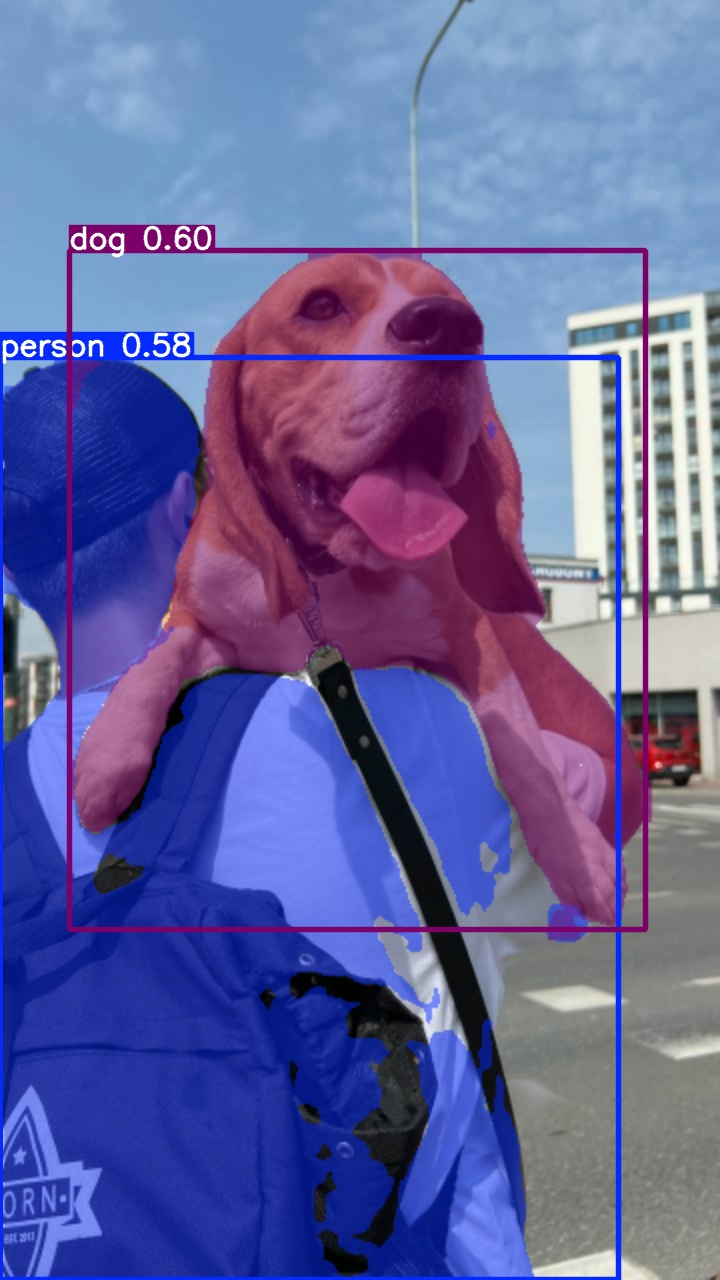

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/predict2/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n-seg.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 1 person, 1 dog, 18.4ms
Speed: 2.8ms preprocess, 18.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[6.9987e+01, 2.5025e+02, 6.4593e+02, 9.2949e+02],
        [7.9004e-01, 3.5712e+02, 6.1851e+02, 1.2798e+03]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.5991, 0.5815], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([16.,  0.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

NameError: name 'segment_annotator' is not defined

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
!pip install roboflow

from roboflow import Roboflow
API_KEY = 'api key

project = rf.workspace("mestrado-wwvn1").project("brain-tumor-instance-segmentation")
version = project.version(1)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Brain-Tumor-Instance-Segmentation-1 in yolov11:: 100%|██████████| 3100/3100 [00:00<00:00, 5995.18it/s]


## Custom Training

In [ ]:
!rm -rf {HOME}/runs/segment/train

In [ ]:
%cd {HOME}

!yolo task=segment mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.101 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/datasets/Brain-Tumor-Instance-Segmentation-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, reti

**NOTE:** The results of the completed training are saved in `{HOME}/runs/segment/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/segment/train/

args.yaml					    MaskF1_curve.png	 train_batch2722.jpg
BoxF1_curve.png					    MaskP_curve.png	 train_batch2.jpg
BoxP_curve.png					    MaskPR_curve.png	 val_batch0_labels.jpg
BoxPR_curve.png					    MaskR_curve.png	 val_batch0_pred.jpg
BoxR_curve.png					    results.csv		 val_batch1_labels.jpg
confusion_matrix_normalized.png			    results.png		 val_batch1_pred.jpg
confusion_matrix.png				    train_batch0.jpg	 val_batch2_labels.jpg
events.out.tfevents.1743766600.ac146ed45f19.4009.0  train_batch1.jpg	 val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch2720.jpg  weights
labels.jpg					    train_batch2721.jpg


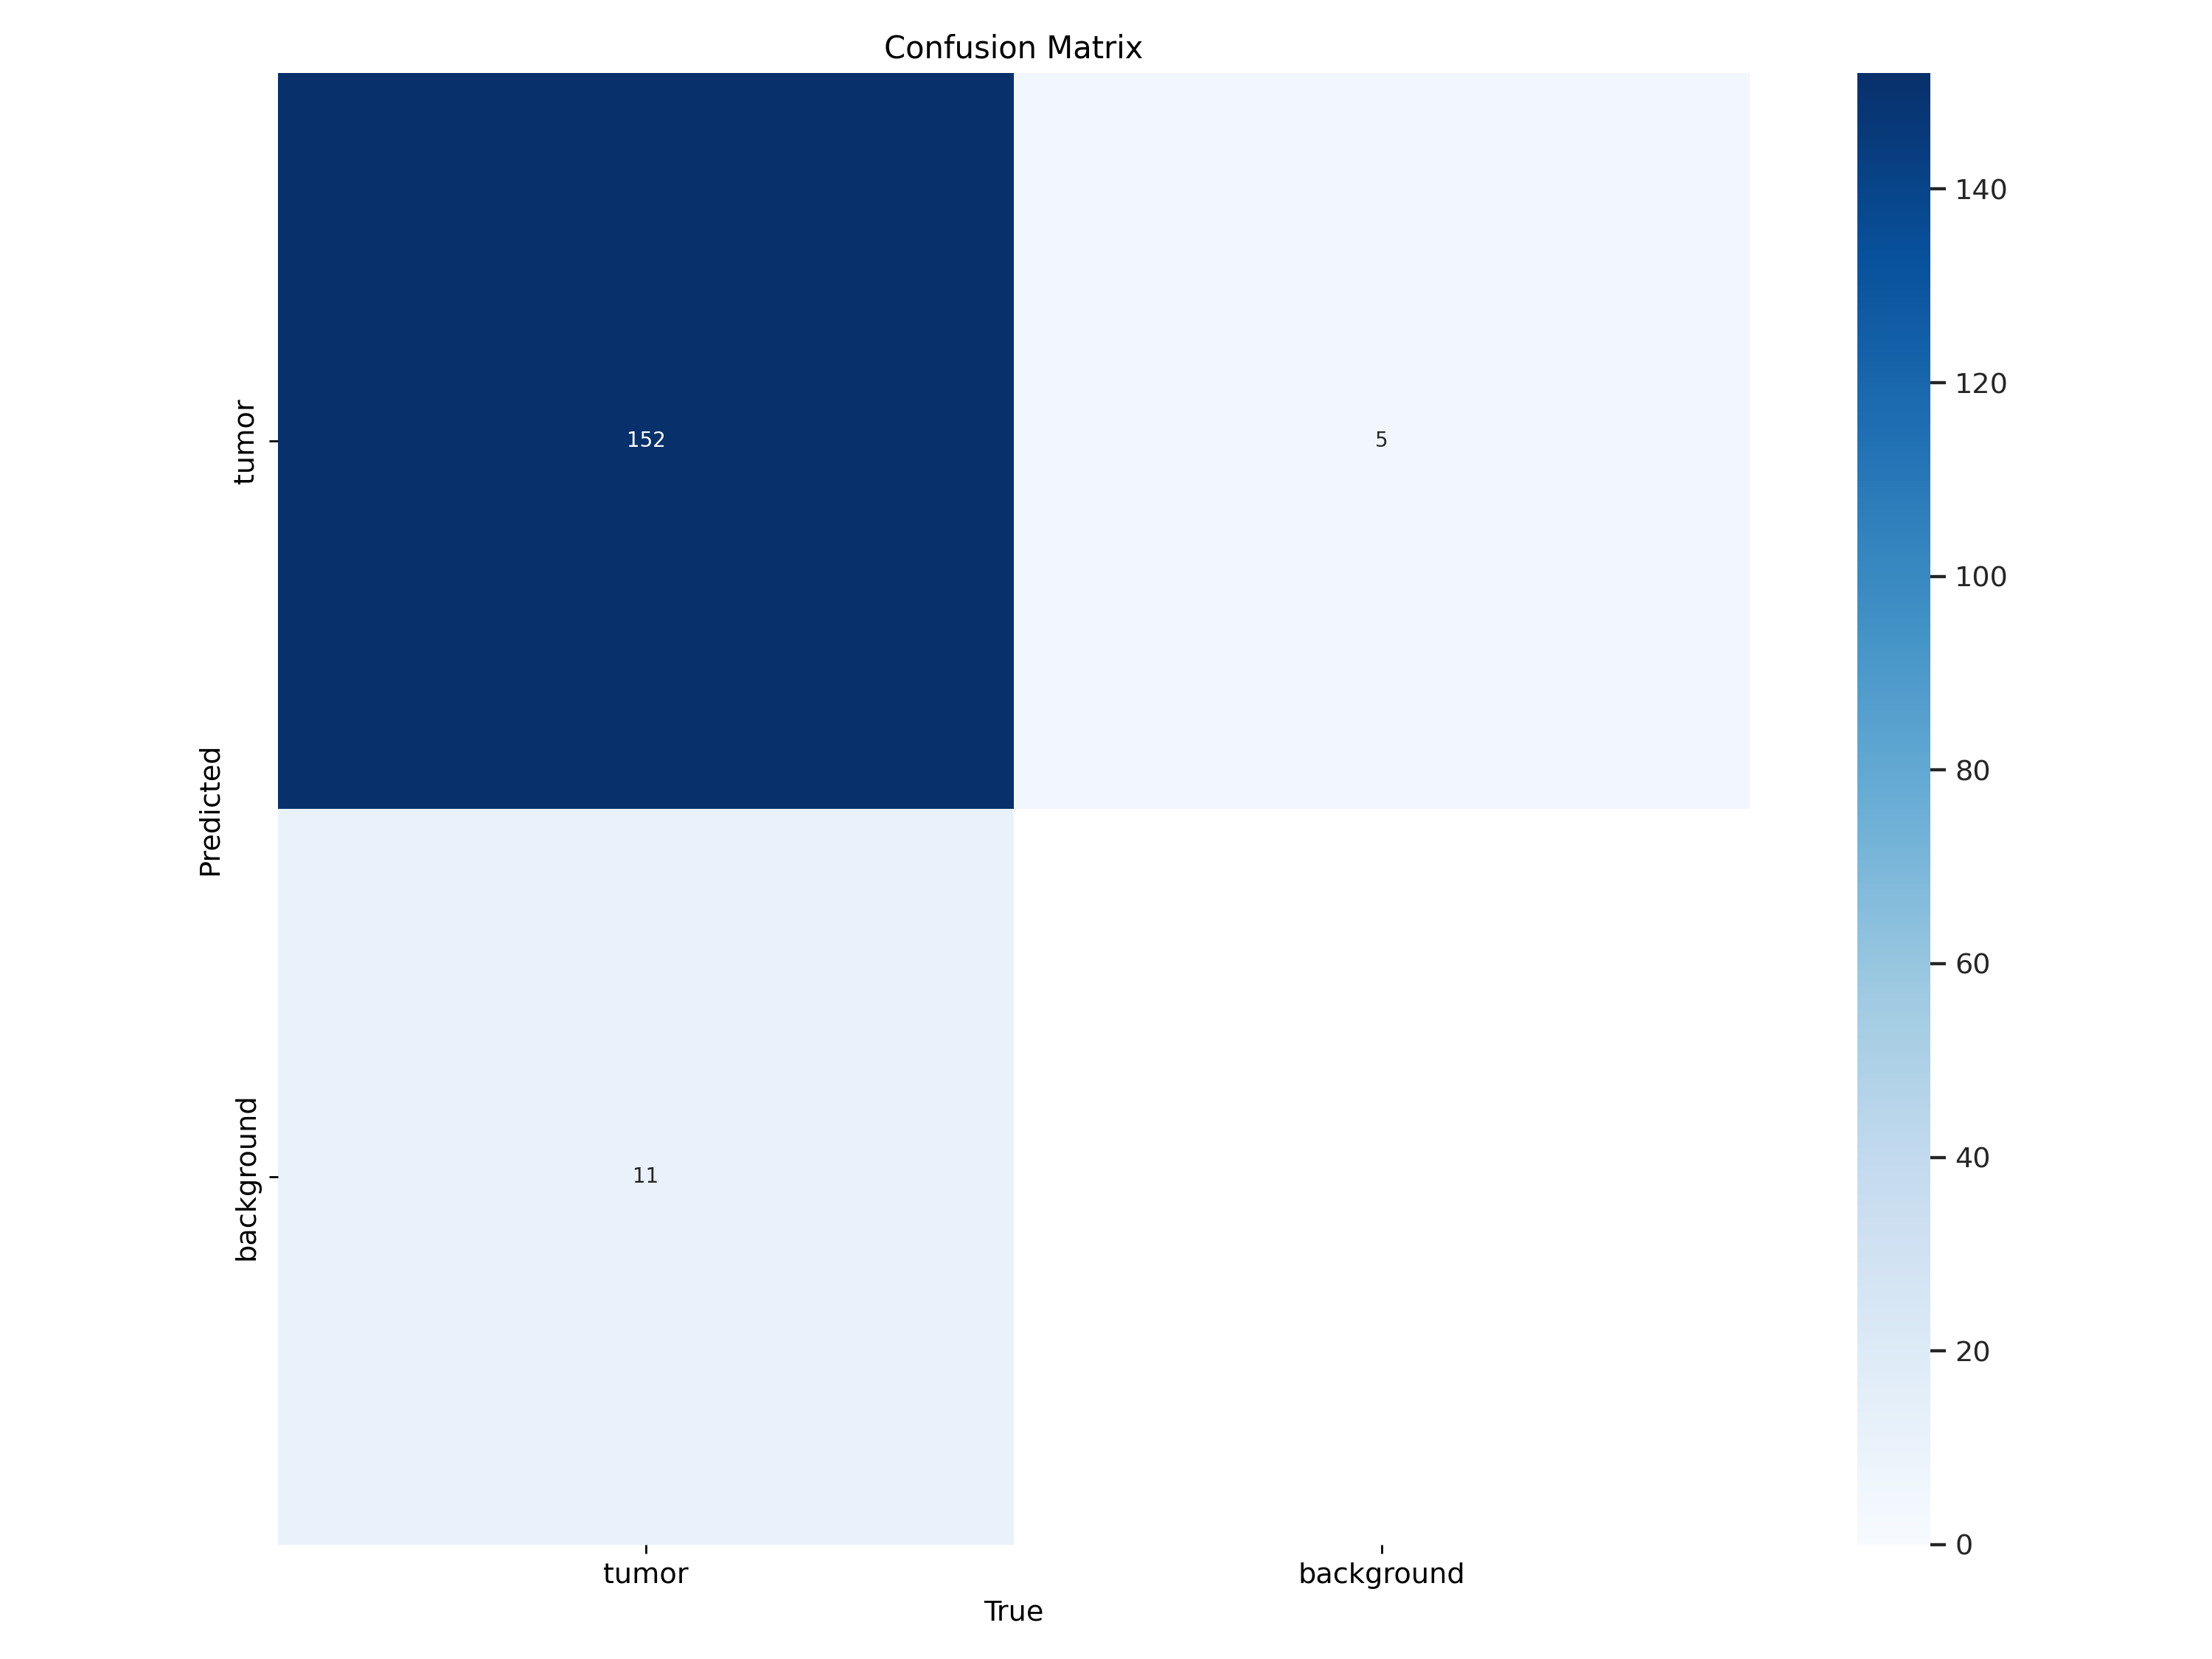

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

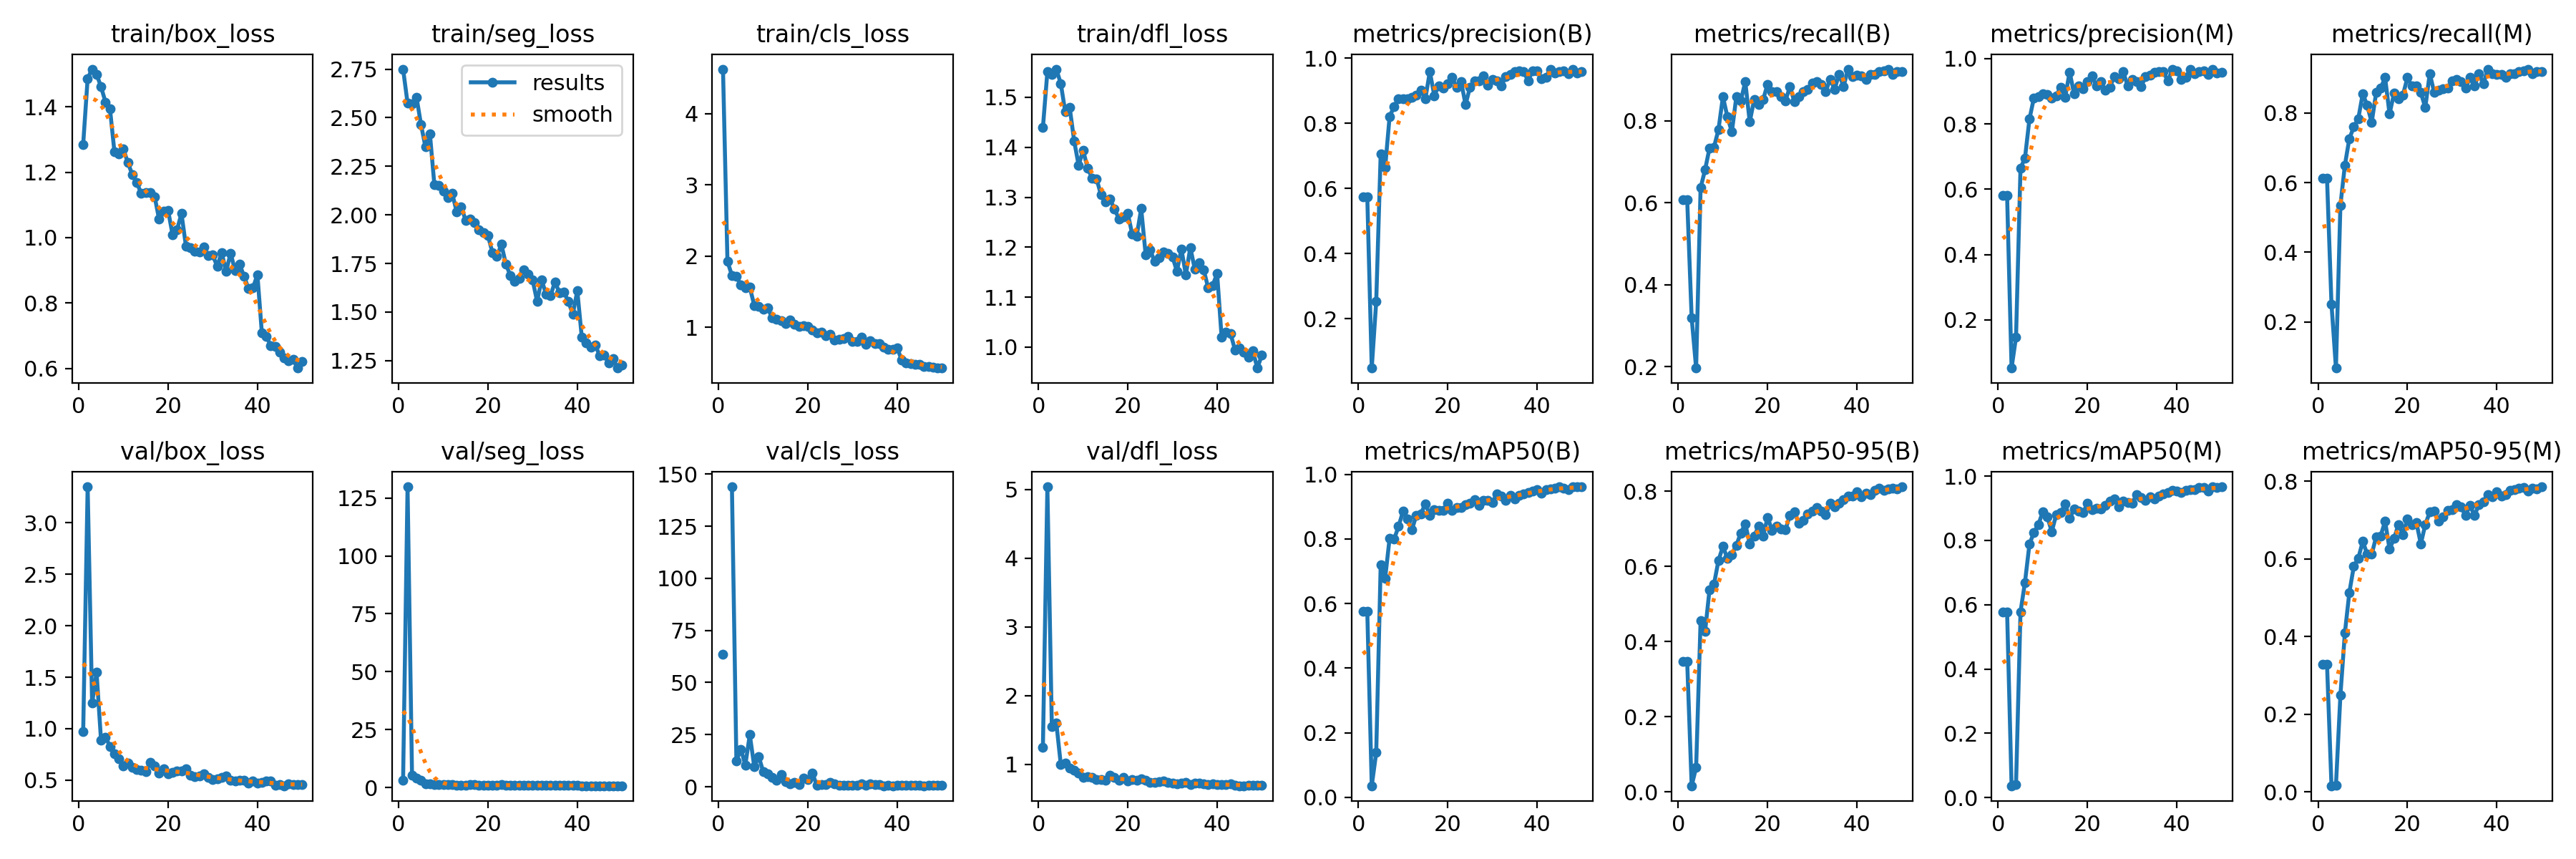

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png')

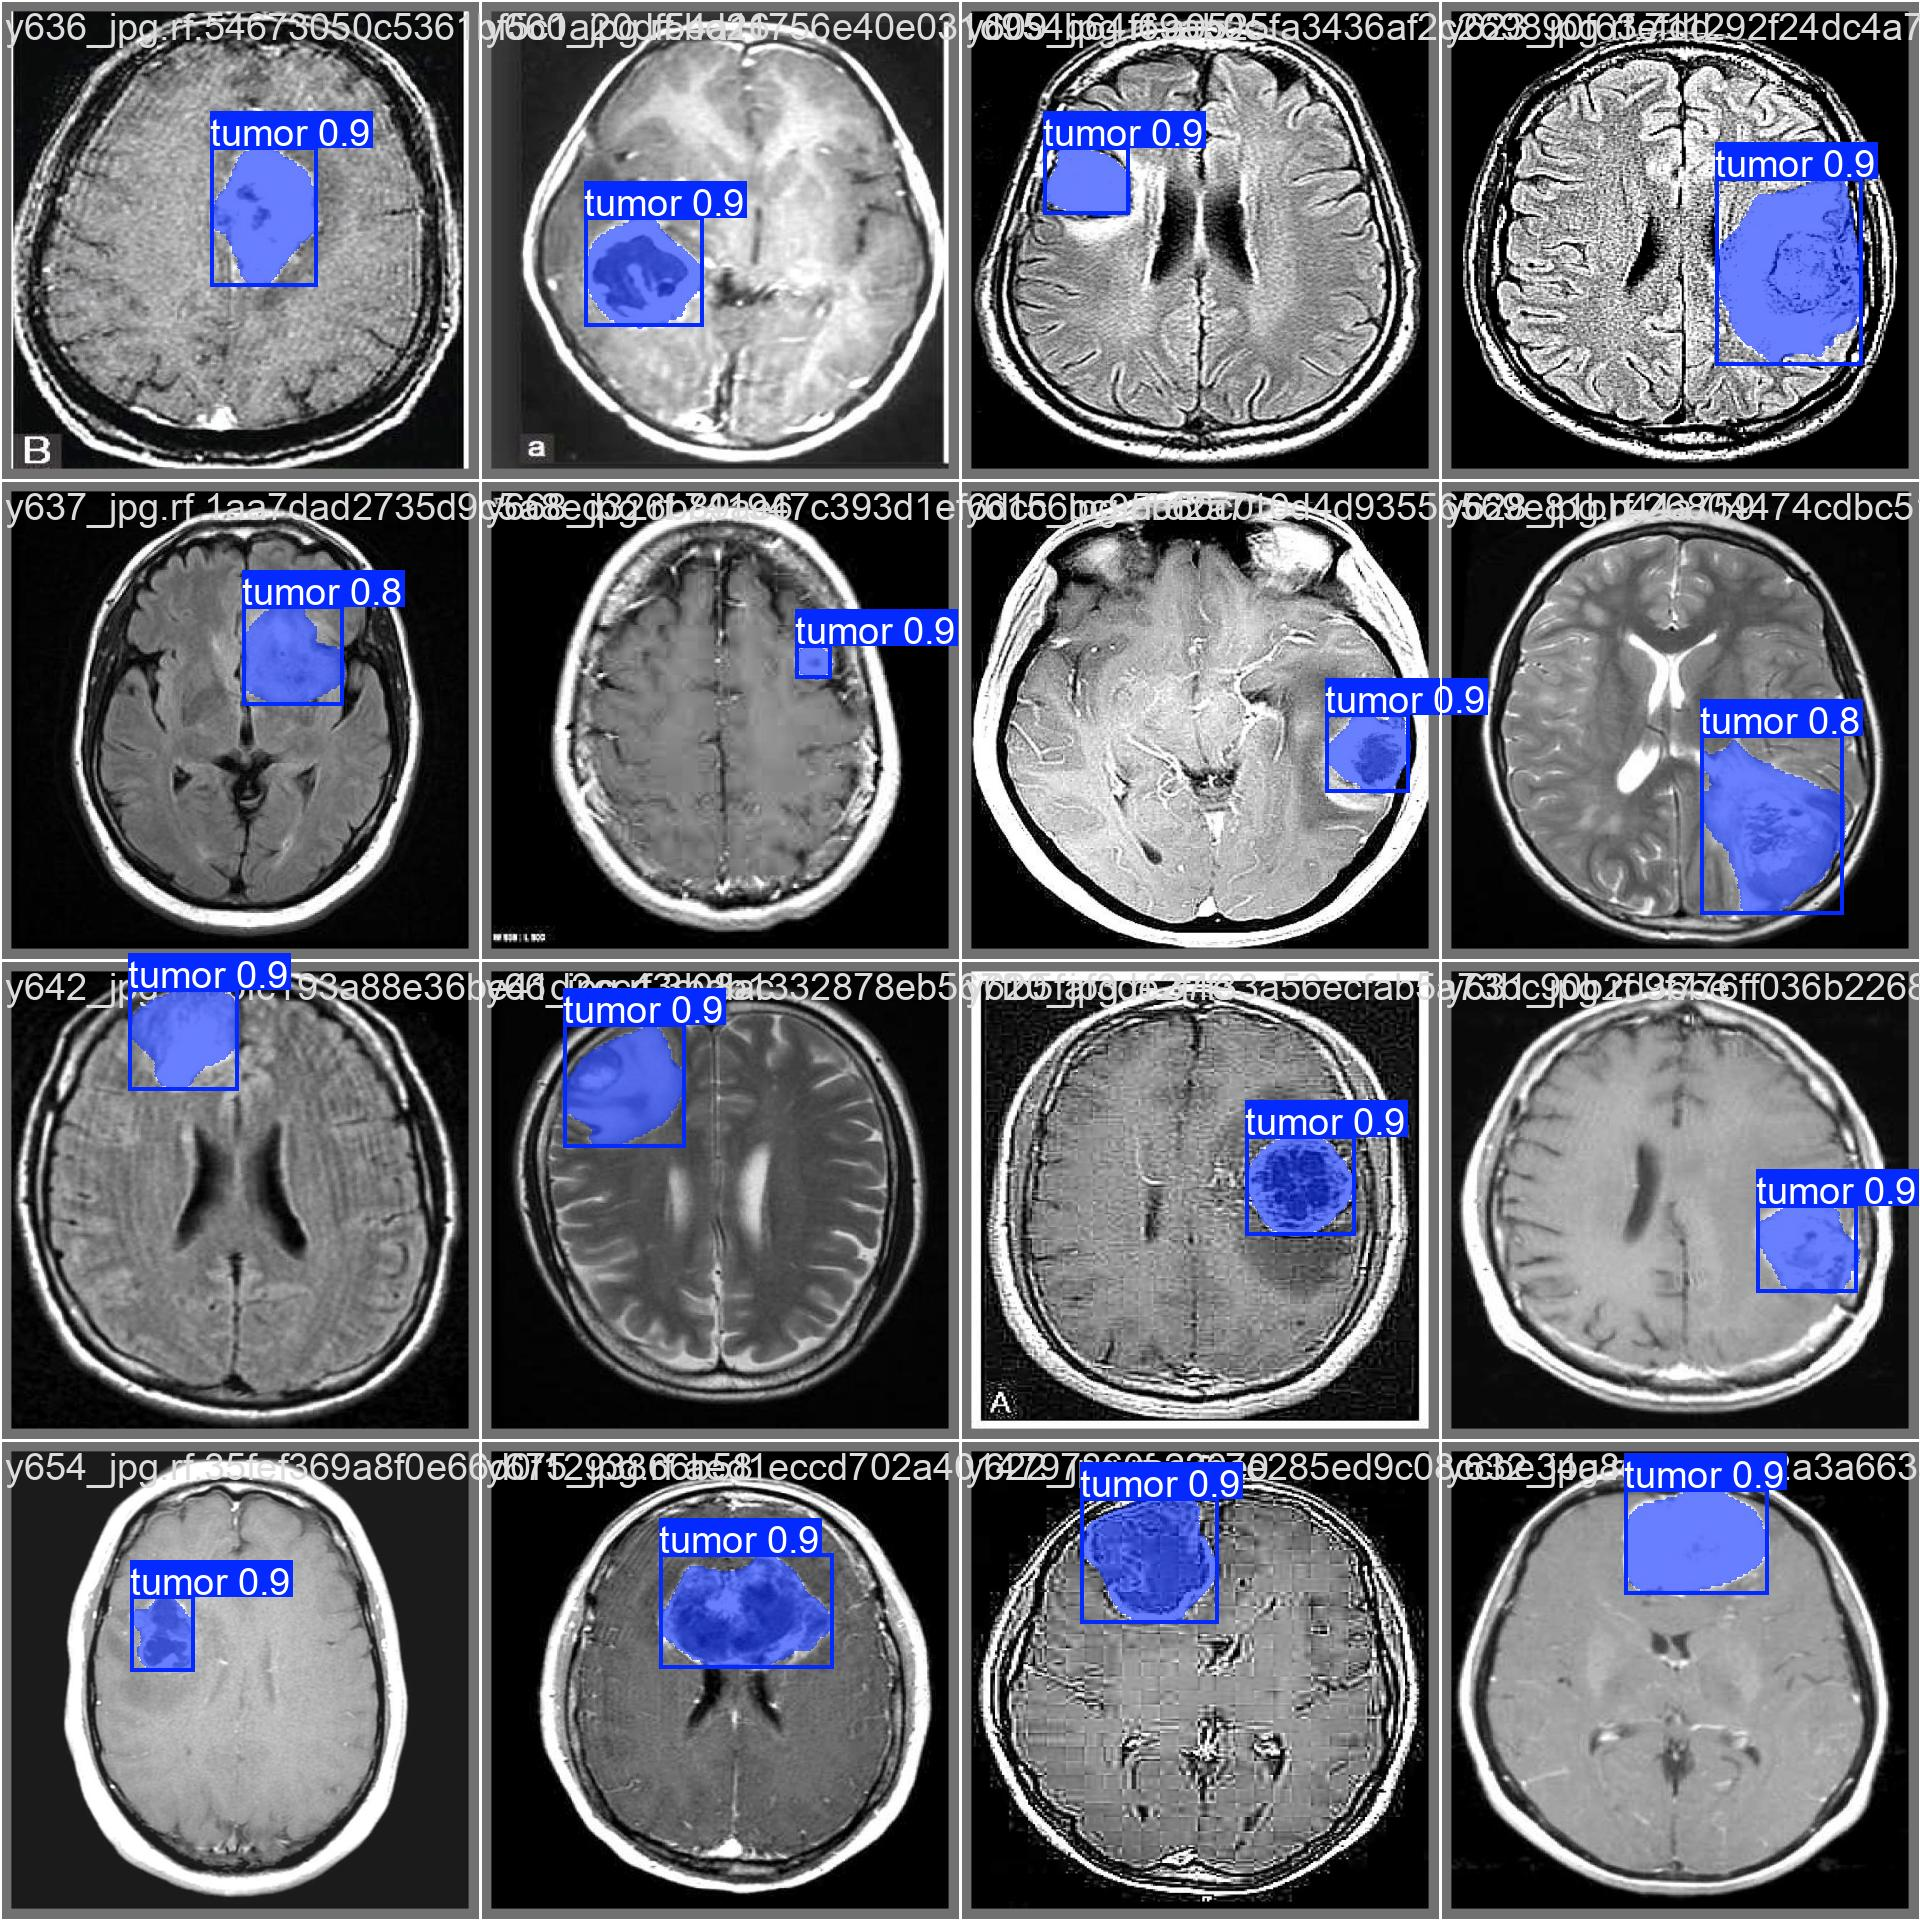

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/labels.cache... 309 images, 150 backgrounds, 0 corrupt: 100% 309/309 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 20/20 [00:07<00:00,  2.63it/s]
                   all        309        163      0.958       0.92      0.961      0.812      0.958       0.92      0.967      0.785
Speed: 2.5ms preprocess, 13.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [ ]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/155 /content/datasets/Brain-Tumor-Instance-Segmentation-1/test/images/no103_jpg.rf.ef2656c5c176f8ab38886fecc7d4b68d.jpg: 640x640 (no detections), 20.3ms
image 2/155 /content/datasets/Brain-Tumor-Instance-Segmentation-1/test/images/no114_jpg.rf.790984e88567f3e3fc021e7463825b56.jpg: 640x640 (no detections), 20.2ms
image 3/155 /content/datasets/Brain-Tumor-Instance-Segmentation-1/test/images/no126_jpg.rf.0e6f02d0f8bfc1f29da5ab052e643508.jpg: 640x640 (no detections), 20.2ms
image 4/155 /content/datasets/Brain-Tumor-Instance-Segmentation-1/test/images/no130_jpg.rf.526e2b9ec2fce45acfcacf92017ba338.jpg: 640x640 (no detections), 20.2ms
image 5/155 /content/datasets/Brain-Tumor-Instance-Segmentation-1/test/images/no133_jpg.rf.3462ffe65631611bc0b642aafd4034a3.jpg: 640x640 (no detections), 20.2ms
image 6/155 /content/da

**NOTE:** Let's take a look at few results.

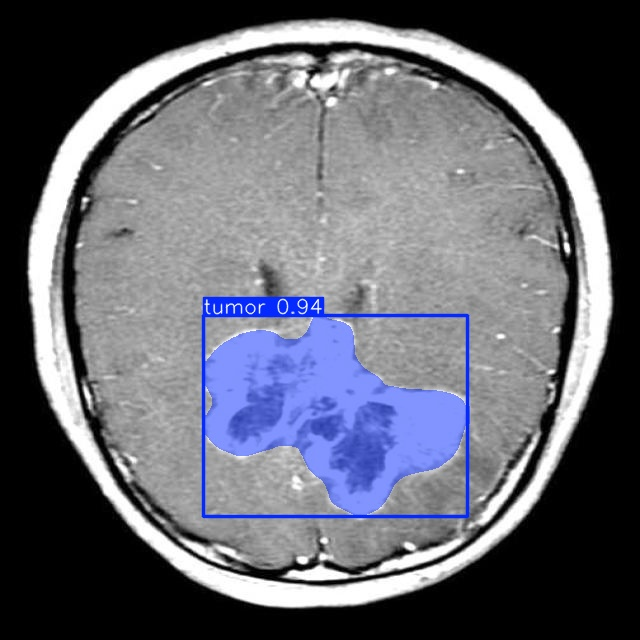

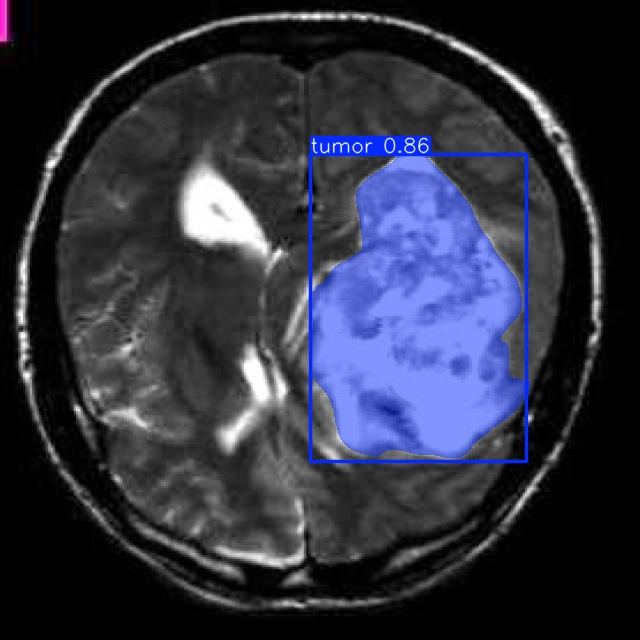

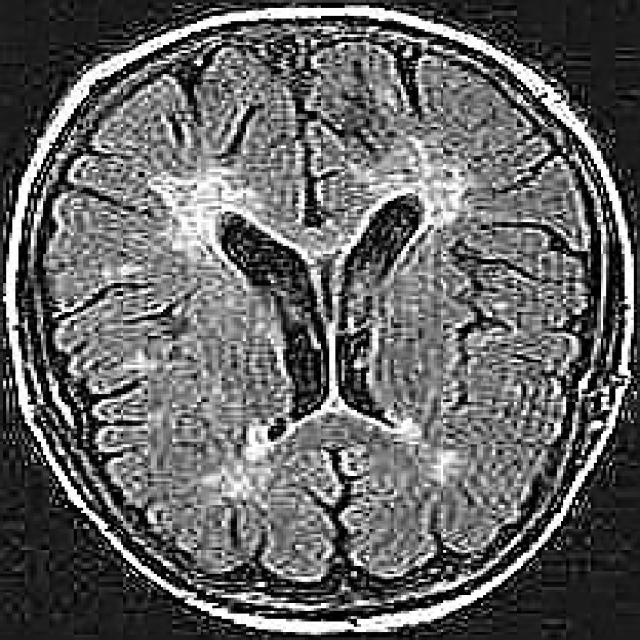

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
!rm -rf /content/gradcam_improved

In [ ]:
# Instala Ultralytics
!pip install ultralytics --quiet

# Imports
import os
import cv2
import torch
import numpy as np
import torch.nn.functional as F
from ultralytics import YOLO
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
from tqdm import tqdm

# Caminhos
model_path = "/content/runs/segment/train/weights/best.pt"
img_dir = "/content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images"
output_dir = "/content/gradcam_sidebyside"
os.makedirs(output_dir, exist_ok=True)

# Modelo
model = YOLO(model_path)
pytorch_model = model.model
pytorch_model.eval()

# Grad-CAM
target_layer = pytorch_model.model[22]
features, gradients = [], []

def forward_hook(module, input, output):
    features.clear()
    features.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.clear()
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Transform
transform = Compose([Resize((640, 640)), ToTensor()])
image_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png"))])

# Loop
for img_name in tqdm(image_files):
    try:
        base_name = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)

        # Pasta da imagem
        image_output_dir = os.path.join(output_dir, base_name)
        os.makedirs(image_output_dir, exist_ok=True)

        # Original
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        input_tensor = transform(img_pil).unsqueeze(0).requires_grad_()

        # Envia para GPU (se necessário)
        device = next(pytorch_model.parameters()).device
        input_tensor = input_tensor.to(device)

        # === Grad-CAM
        _ = pytorch_model(input_tensor)
        score = features[0].sum()
        score.backward()

        fmap = features[0].detach()
        grads = gradients[0].detach()
        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * fmap).sum(dim=1).squeeze()
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        cam_np = cam.cpu().numpy()
        cam_resized = cv2.resize(cam_np, (img_rgb.shape[1], img_rgb.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # === Predição do YOLO com segmentação, label e confiança
        results = model.predict(img_path, conf=0.3, save=False, imgsz=640)
        pred_plot = results[0].plot()  # ← aqui usamos o padrão completo do YOLO

        # === Salvar 3 imagens
        cv2.imwrite(os.path.join(image_output_dir, f"{base_name}_original.jpg"), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(image_output_dir, f"{base_name}_gradcam.jpg"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(image_output_dir, f"{base_name}_predict.jpg"), cv2.cvtColor(pred_plot, cv2.COLOR_RGB2BGR))

    except Exception as e:
        print(f"Erro em {img_name}: {e}")


  0%|          | 0/309 [00:00<?, ?it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no107_jpg.rf.766c3ce7c2c5ade90c34dcf98d5ea183.jpg: 640x640 (no detections), 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  0%|          | 1/309 [00:01<06:14,  1.22s/it]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no109_jpg.rf.0863b6c5b451eec5617f3df080bc7d15.jpg: 640x640 (no detections), 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no121_jpg.rf.8339eb954b6b81d492406a6c1d1f2bb0.jpg: 640x640 (no detections), 16.5ms
Speed: 1.9ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  1%|          | 3/309 [00:01<01:55,  2.65it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no132_jpg.rf.25fa248565c0f78351f4dba009584768.jpg: 640x640 (no detections), 16.5ms
Speed: 2.3ms preprocess, 16.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no135_jpg.rf.1d628b3db1f77cc8d832650ab5c50730.jpg: 640x640 (no detections), 17.9ms
Speed: 2.7ms preprocess, 17.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 5/309 [00:01<01:10,  4.33it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no137_jpg.rf.55acbe0de089d403930d265dd9c99be4.jpg: 640x640 (no detections), 19.0ms
Speed: 3.9ms preprocess, 19.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no142_jpg.rf.745e1b247ba5f06426fd1dd4f4d188e3.jpg: 640x640 (no detections), 26.1ms
Speed: 2.7ms preprocess, 26.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  2%|▏         | 7/309 [00:01<00:53,  5.66it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no148_jpg.rf.2c9da7a9510ebe91e8a94066d5a3aa19.jpg: 640x640 (no detections), 18.7ms
Speed: 2.5ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no149_jpg.rf.0292f9da3bdf24b9a795094e414fd51a.jpg: 640x640 (no detections), 20.0ms
Speed: 2.8ms preprocess, 20.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  3%|▎         | 9/309 [00:01<00:43,  6.91it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no155_jpg.rf.3b36bfb82668a0b826c94c6fbaddc947.jpg: 640x640 (no detections), 14.3ms
Speed: 2.7ms preprocess, 14.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no159_jpg.rf.e6658ce716985f07051450edfab08dd7.jpg: 640x640 (no detections), 20.8ms
Speed: 2.6ms preprocess, 20.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▎         | 11/309 [00:02<00:37,  7.91it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no171_jpg.rf.7f6f4ab9fe3bd63ffa07aa46e00eac0a.jpg: 640x640 (no detections), 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no175_jpg.rf.1c4631ac7b65defe1d8adfd721b79c3c.jpg: 640x640 (no detections), 14.1ms
Speed: 2.6ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  4%|▍         | 13/309 [00:02<00:33,  8.85it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no184_jpg.rf.719b44811f78cb2ba9a43ab1b4e09639.jpg: 640x640 (no detections), 15.1ms
Speed: 4.3ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no187_jpg.rf.744cac5094c00abe1c58bdecdd7b7182.jpg: 640x640 (no detections), 15.6ms
Speed: 2.5ms preprocess, 15.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  5%|▍         | 15/309 [00:02<00:31,  9.21it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no194_jpg.rf.24cce05cab15571f6d48ba5e6e0e54a7.jpg: 640x640 (no detections), 14.2ms
Speed: 2.8ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no195_jpg.rf.ec7dce288b902135712b6edc6a899ec8.jpg: 640x640 (no detections), 13.7ms
Speed: 2.5ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 17/309 [00:02<00:29,  9.85it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no203_jpg.rf.9b3f0806e8da37f77c8ee4bd58c127fa.jpg: 640x640 (no detections), 18.9ms
Speed: 2.5ms preprocess, 18.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no20_jpg.rf.af78a2bd896eaf24eb345db92b47509c.jpg: 640x640 (no detections), 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  6%|▌         | 19/309 [00:02<00:28, 10.21it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no215_jpg.rf.b3863e997e848db966ad59bdf0148c77.jpg: 640x640 (no detections), 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no218_jpg.rf.e161b499386841b6f50a2d912db823d1.jpg: 640x640 (no detections), 14.6ms
Speed: 3.0ms preprocess, 14.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 21/309 [00:03<00:27, 10.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no21_jpg.rf.ff0a92ff011a3944a1e3ab3a9468700e.jpg: 640x640 (no detections), 13.4ms
Speed: 2.5ms preprocess, 13.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no224_jpg.rf.c1e49c0b249f49bbf714984531038dc5.jpg: 640x640 (no detections), 19.6ms
Speed: 2.6ms preprocess, 19.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  7%|▋         | 23/309 [00:03<00:26, 10.63it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no225_jpg.rf.4898c4939c366a74080b5d8497e74a3c.jpg: 640x640 (no detections), 15.8ms
Speed: 3.3ms preprocess, 15.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no228_jpg.rf.4e268adaf6c44c49560ea2ddcac107fa.jpg: 640x640 (no detections), 17.4ms
Speed: 3.8ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


  8%|▊         | 25/309 [00:03<00:27, 10.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no239_jpg.rf.1ea8ce977e08d6423199f0f205b8a73e.jpg: 640x640 (no detections), 18.8ms
Speed: 2.6ms preprocess, 18.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no268_jpg.rf.e1f69ddec521fef62839de2f4fe0fb1e.jpg: 640x640 (no detections), 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


  9%|▊         | 27/309 [00:03<00:27, 10.28it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no274_jpg.rf.be0b9fac95fdf2a61fea215fc23656f8.jpg: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no276_jpg.rf.0f457f3ae1390d4aa6585d0a950827f2.jpg: 640x640 (no detections), 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


  9%|▉         | 29/309 [00:03<00:25, 11.20it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no286_jpg.rf.e3f4fafa1c5dea3cd1a85050d7901312.jpg: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no289_jpg.rf.86e76878a72b77f0decd2aeb6fd9d89c.jpg: 640x640 (no detections), 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 10%|█         | 31/309 [00:03<00:23, 11.85it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no296_jpg.rf.0bb615b8c801899d22cab3582b8f9644.jpg: 640x640 (no detections), 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no300_jpg.rf.d036efb34e827d1a79199b9a2c91a780.jpg: 640x640 (no detections), 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 11%|█         | 33/309 [00:04<00:21, 12.73it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no304_jpg.rf.eeb97f26b49e7f554324a17f37bf06d7.jpg: 640x640 (no detections), 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no305_jpg.rf.23e62d0ac9729af9e7d8cba3277a461e.jpg: 640x640 (no detections), 13.7ms
Speed: 2.7ms preprocess, 13.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 11%|█▏        | 35/309 [00:04<00:20, 13.35it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no306_jpg.rf.1837dfc6127f255d2f63d49375c74d64.jpg: 640x640 (no detections), 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no318_jpg.rf.9ad973a281e9bfce4fed67375f01f1c6.jpg: 640x640 (no detections), 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 12%|█▏        | 37/309 [00:04<00:19, 13.83it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no325_jpg.rf.27c93f4a161ede4898996d54c3298484.jpg: 640x640 (no detections), 12.3ms
Speed: 2.0ms preprocess, 12.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no326_jpg.rf.4c76ea01ccaade657b9faf397d37a562.jpg: 640x640 (no detections), 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 39/309 [00:04<00:19, 13.83it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no331_jpg.rf.8cb841dd3ba6ffaf86e672142066632f.jpg: 640x640 (no detections), 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no333_jpg.rf.51a4ad4b3683a4657fb9fd165141606f.jpg: 640x640 (no detections), 12.9ms
Speed: 2.1ms preprocess, 12.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 13%|█▎        | 41/309 [00:04<00:18, 14.21it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no335_jpg.rf.006a3106e2f5bb97d02bd594fb407487.jpg: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no340_jpg.rf.f2a1c4318a3a41f75924386771f24bca.jpg: 640x640 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 14%|█▍        | 43/309 [00:04<00:18, 14.54it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no342_jpg.rf.1b564a2585b73cea69b06c72dc3460ad.jpg: 640x640 (no detections), 13.5ms
Speed: 1.9ms preprocess, 13.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no343_jpg.rf.01edd4d1efcc0f4727c2a8c75753bc35.jpg: 640x640 (no detections), 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▍        | 45/309 [00:04<00:18, 14.57it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no346_jpg.rf.5288fe087aff3101e51aa895f190daff.jpg: 640x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no348_jpg.rf.6f0d4036b01cae8cd01ac21ca2468522.jpg: 640x640 (no detections), 16.0ms
Speed: 2.4ms preprocess, 16.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 15%|█▌        | 47/309 [00:04<00:17, 14.65it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no34_jpg.rf.3e7782f5f4126c09bf18beebd2a5f2d4.jpg: 640x640 (no detections), 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no354_jpg.rf.06b39a667d7de509d71222d20bb4c30a.jpg: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 16%|█▌        | 49/309 [00:05<00:17, 14.76it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no358_jpg.rf.ca62d9a3373eb686d12d9722787e55f3.jpg: 640x640 (no detections), 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no360_jpg.rf.327f83d1fc87dfe413a1f80662f4a46e.jpg: 640x640 (no detections), 11.7ms
Speed: 2.5ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 51/309 [00:05<00:17, 14.85it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no366_jpg.rf.07c82cca0898b22bcbff2b25e25ee9aa.jpg: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no367_jpg.rf.d99b4e7a9a5da82891e5b77c5df1adea.jpg: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 17%|█▋        | 53/309 [00:05<00:17, 15.01it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no368_jpg.rf.d63fc8f02c1ff79255b285e77b866457.jpg: 640x640 (no detections), 19.3ms
Speed: 2.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no369_jpg.rf.322e4d2077db5bb40fc05a7b431ccda4.jpg: 640x640 (no detections), 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 55/309 [00:05<00:17, 14.66it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no36_jpg.rf.773a45b870e0f1c020f75276e7f246e1.jpg: 640x640 (no detections), 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no374_jpg.rf.487c545ae56b379033491e2a7a95822d.jpg: 640x640 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 18%|█▊        | 57/309 [00:05<00:17, 14.78it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no377_jpg.rf.9527322f9b2558810c9d033c6765baf2.jpg: 640x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no387_jpg.rf.130b52d538b3f4382a59fe04b2666c52.jpg: 640x640 (no detections), 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 19%|█▉        | 59/309 [00:05<00:16, 14.82it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no390_jpg.rf.d39637932c5eef7e1f696b32a422c4b8.jpg: 640x640 (no detections), 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no392_jpg.rf.b62c8b83f37b02b89c58d2a2d4efdae8.jpg: 640x640 (no detections), 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 20%|█▉        | 61/309 [00:05<00:16, 14.97it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no396_jpg.rf.c88b7c9003de07dd9d67863a52ab105f.jpg: 640x640 (no detections), 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no400_jpg.rf.8e7c0c9f4d1408fd73c8920281db0253.jpg: 640x640 (no detections), 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 20%|██        | 63/309 [00:06<00:16, 15.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no404_jpg.rf.df7e61b6abf0a900a0f4f55db278f8a7.jpg: 640x640 (no detections), 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no414_jpg.rf.f1226257de6c0e205e425ecffccbf5b3.jpg: 640x640 (no detections), 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 21%|██        | 65/309 [00:06<00:15, 15.25it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no419_jpg.rf.c6e6318e97d8166e2756d9fac4d261ed.jpg: 640x640 (no detections), 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no420_jpg.rf.82b851b5fe72511958a256827b84adb1.jpg: 640x640 (no detections), 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 67/309 [00:06<00:15, 15.17it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no422_jpg.rf.70b256909a7c3da00a8e49fc0f6ec189.jpg: 640x640 (no detections), 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no429_jpg.rf.6f096debd9add2e470944fbd02c51510.jpg: 640x640 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 22%|██▏       | 69/309 [00:06<00:15, 15.23it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no440_jpg.rf.f799688d3b7055d2f03fb36998d764ea.jpg: 640x640 (no detections), 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no443_jpg.rf.57e99f11d7d71575949cc4bf5eb890a4.jpg: 640x640 (no detections), 10.8ms
Speed: 1.9ms preprocess, 10.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 23%|██▎       | 71/309 [00:06<00:15, 14.93it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no446_jpg.rf.d9e67093f2a36e3e5f30a4ed3dbf4c71.jpg: 640x640 (no detections), 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no448_jpg.rf.56e882a9043e9ce872afad432b43423d.jpg: 640x640 (no detections), 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▎       | 73/309 [00:06<00:15, 15.11it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no456_jpg.rf.5d8951b37557c9414e1fb7ab10e8210f.jpg: 640x640 (no detections), 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no457_jpg.rf.027c482551f228b0ab7b89f1f1b3f89e.jpg: 640x640 (no detections), 15.7ms
Speed: 2.5ms preprocess, 15.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 24%|██▍       | 75/309 [00:06<00:15, 14.91it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no462_jpg.rf.ae4da428d9c7f7357d551e58ddb148fd.jpg: 640x640 (no detections), 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no463_jpg.rf.4f81b80ee0fb95e876de0d269c18a6da.jpg: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 25%|██▍       | 77/309 [00:06<00:15, 15.18it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no466_jpg.rf.3efa17dd71e5351ef76beb493d6b5ce2.jpg: 640x640 (no detections), 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no472_jpg.rf.d4fc50663969630b7e351e7726772d8e.jpg: 640x640 (no detections), 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 79/309 [00:07<00:15, 15.16it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no474_jpg.rf.06528368c3996f689d4cd38019903829.jpg: 640x640 (no detections), 13.7ms
Speed: 2.5ms preprocess, 13.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no479_jpg.rf.f5ed313cad1472df5b31a843bc089ada.jpg: 640x640 (no detections), 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 26%|██▌       | 81/309 [00:07<00:15, 14.95it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no482_jpg.rf.8baa5375af383d7f37c70a96fe515f65.jpg: 640x640 (no detections), 18.6ms
Speed: 2.6ms preprocess, 18.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no492_jpg.rf.07ac3d42c33f3faeedc76d17b1955f47.jpg: 640x640 (no detections), 20.7ms
Speed: 6.2ms preprocess, 20.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 27%|██▋       | 83/309 [00:07<00:17, 13.25it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no494_jpg.rf.fa0b82cb93a78e2cacea0f751534913e.jpg: 640x640 (no detections), 25.6ms
Speed: 2.6ms preprocess, 25.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no498_jpg.rf.5e6175d010494d0cd921b08db087ffce.jpg: 640x640 (no detections), 32.2ms
Speed: 2.6ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 85/309 [00:07<00:20, 10.67it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no49_jpg.rf.f72542360c874ff7ac4fa65f250c6ee2.jpg: 640x640 (no detections), 27.0ms
Speed: 2.9ms preprocess, 27.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no500_jpg.rf.27eb0554588d3e9f59b47e6e6c0b491c.jpg: 640x640 (no detections), 45.6ms
Speed: 3.1ms preprocess, 45.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 28%|██▊       | 87/309 [00:08<00:23,  9.25it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no501_jpg.rf.40b56e6705ac871211d562eacab244b3.jpg: 640x640 (no detections), 32.2ms
Speed: 3.0ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no504_jpg.rf.b683418f94f87a70c62a5dd00ca1ff30.jpg: 640x640 (no detections), 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 89/309 [00:08<00:23,  9.34it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no509_jpg.rf.a9c1102a7ca973028130e4f918ec15ad.jpg: 640x640 (no detections), 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no50_jpg.rf.517c171f29fc3570a325820a9d1ecdd8.jpg: 640x640 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 29%|██▉       | 91/309 [00:08<00:20, 10.55it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no510_jpg.rf.e1fea0ba682cc47388221e2ef8e1ae23.jpg: 640x640 (no detections), 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no520_jpg.rf.e6a89a7552b93b85bd82a17f9198f589.jpg: 640x640 (no detections), 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 30%|███       | 93/309 [00:08<00:18, 11.51it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no521_jpg.rf.521e5bf0d950f80554b45e58767e3bdf.jpg: 640x640 (no detections), 18.7ms
Speed: 2.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no523_jpg.rf.b30489dabe80fed85fd9095bd7e3c833.jpg: 640x640 1 tumor, 14.3ms
Speed: 2.0ms preprocess, 14.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 31%|███       | 95/309 [00:08<00:17, 12.01it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no524_jpg.rf.8fca2f0b325cbb983ad91216ab203fb0.jpg: 640x640 (no detections), 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no529_jpg.rf.1e3d1a7e44d69a4461026f7f1072e294.jpg: 640x640 (no detections), 13.7ms
Speed: 2.4ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


 31%|███▏      | 97/309 [00:08<00:16, 12.77it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no536_jpg.rf.95a659fe6bd387adba2bdd2be5cb886d.jpg: 640x640 (no detections), 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no548_jpg.rf.2f07befd8b00c0b428306ed077799e33.jpg: 640x640 (no detections), 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 32%|███▏      | 99/309 [00:08<00:15, 13.26it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no551_jpg.rf.9b4242c09c607e0d943d596a692720bf.jpg: 640x640 (no detections), 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no552_jpg.rf.463349fa0001dda8229c99fa742c278b.jpg: 640x640 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 101/309 [00:09<00:15, 13.74it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no559_jpg.rf.e70200e9488ec1b2eecc7468fa6a646f.jpg: 640x640 (no detections), 19.0ms
Speed: 2.7ms preprocess, 19.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no567_jpg.rf.7cbe7635fcb404dc02f0e9045f0433f3.jpg: 640x640 (no detections), 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 33%|███▎      | 103/309 [00:09<00:15, 13.63it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no56_jpg.rf.6202866674c40b6de4cc63eb59c4e028.jpg: 640x640 (no detections), 12.0ms
Speed: 3.1ms preprocess, 12.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no574_jpg.rf.9512a2f9e8355d8af9e5c6e47366e829.jpg: 640x640 (no detections), 11.9ms
Speed: 2.7ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 34%|███▍      | 105/309 [00:09<00:14, 13.95it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no579_jpg.rf.b692a291a98923d261b3fbba1a2727d1.jpg: 640x640 (no detections), 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no581_jpg.rf.6afe7a40866d8b04397b931f47ef17e0.jpg: 640x640 (no detections), 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▍      | 107/309 [00:09<00:14, 14.13it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no584_jpg.rf.40ae88fbe1c0d027cca7c227f79c31ba.jpg: 640x640 (no detections), 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no586_jpg.rf.46ad7c5e0fc75d52b088ee8bd53b551f.jpg: 640x640 (no detections), 11.8ms
Speed: 1.9ms preprocess, 11.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 35%|███▌      | 109/309 [00:09<00:14, 13.87it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no589_jpg.rf.2d25e9c6023bf25062a8bdf8ecee640e.jpg: 640x640 (no detections), 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no590_jpg.rf.17db8b512261e798c72ccb1df72e2a46.jpg: 640x640 (no detections), 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 36%|███▌      | 111/309 [00:09<00:13, 14.23it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no592_jpg.rf.fa0ca941556020a023fea676cfd332ad.jpg: 640x640 (no detections), 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no594_jpg.rf.6d344d0f6cc53c4adf32bf5c623b27a0.jpg: 640x640 (no detections), 15.2ms
Speed: 2.4ms preprocess, 15.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 113/309 [00:09<00:13, 14.35it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no595_jpg.rf.e85fc7417e722961a984aafff2acedca.jpg: 640x640 (no detections), 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no602_jpg.rf.750f8c3587566bee470ce43aab5c9482.jpg: 640x640 (no detections), 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 37%|███▋      | 115/309 [00:10<00:13, 14.47it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no603_jpg.rf.cf8ed35d24084ab42b78b8f3cf91765d.jpg: 640x640 (no detections), 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no609_jpg.rf.4af912317b68d7c609b6e31ad2e0bb0b.jpg: 640x640 (no detections), 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 38%|███▊      | 117/309 [00:10<00:13, 14.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no60_jpg.rf.0e5c55111a87fe29cee3dfab4ae5a454.jpg: 640x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no613_jpg.rf.fd29c7ab39afe3edf4a699f149478f0c.jpg: 640x640 (no detections), 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▊      | 119/309 [00:10<00:13, 14.57it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no615_jpg.rf.5cf9245225938021af118fd282a9f7d3.jpg: 640x640 (no detections), 12.4ms
Speed: 2.0ms preprocess, 12.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no620_jpg.rf.825cb5db5b7ef08c811e3825eb5f2bf9.jpg: 640x640 (no detections), 14.1ms
Speed: 3.1ms preprocess, 14.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 39%|███▉      | 121/309 [00:10<00:12, 14.47it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no623_jpg.rf.bf47678a86bfe1cecae6593ffd56878f.jpg: 640x640 (no detections), 12.7ms
Speed: 2.5ms preprocess, 12.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no62_jpg.rf.c8df7a236b57e21b173df965342698d2.jpg: 640x640 (no detections), 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 40%|███▉      | 123/309 [00:10<00:13, 14.31it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no63_jpg.rf.6109d20b37745f46e33d70be68ee141a.jpg: 640x640 (no detections), 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no641_jpg.rf.516d5490fd67780e284cdfa1af0ad381.jpg: 640x640 (no detections), 31.6ms
Speed: 2.7ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 40%|████      | 125/309 [00:10<00:14, 12.31it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no647_jpg.rf.fb3d8aea5112a09e1d360346eb34b971.jpg: 640x640 (no detections), 18.9ms
Speed: 2.9ms preprocess, 18.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no648_jpg.rf.b48f8446e42b379acf0fdfb845aef813.jpg: 640x640 (no detections), 31.6ms
Speed: 2.4ms preprocess, 31.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 41%|████      | 127/309 [00:11<00:17, 10.67it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no649_jpg.rf.03257788562ea1b0542642412f6426df.jpg: 640x640 (no detections), 18.8ms
Speed: 2.4ms preprocess, 18.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no652_jpg.rf.96caf8a68b926a959bf5df5eccd45cfc.jpg: 640x640 (no detections), 23.4ms
Speed: 2.7ms preprocess, 23.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 129/309 [00:11<00:17, 10.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no662_jpg.rf.25b77e8be94554296fc56c02a8e31a7d.jpg: 640x640 (no detections), 19.6ms
Speed: 2.7ms preprocess, 19.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no663_jpg.rf.5a08cc776c3d8f0c2674be768d428c24.jpg: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 42%|████▏     | 131/309 [00:11<00:17,  9.96it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no671_jpg.rf.20335ce1fd0c26f24de3c1e3745a63b1.jpg: 640x640 (no detections), 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no672_jpg.rf.91e372eb999d336d72fbaa63f4866c9c.jpg: 640x640 (no detections), 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 43%|████▎     | 133/309 [00:11<00:15, 11.03it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no676_jpg.rf.cac1c875e627a53844d5f206c9557186.jpg: 640x640 (no detections), 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no681_jpg.rf.be3933ec3eeba8d0e79ea2dcda9ed846.jpg: 640x640 (no detections), 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▎     | 135/309 [00:11<00:14, 11.69it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no690_jpg.rf.02b9b199c3c7e46e223521115f53e2f5.jpg: 640x640 (no detections), 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no695_jpg.rf.06b08100a6f69475178ecfcc4cad0511.jpg: 640x640 (no detections), 14.1ms
Speed: 3.0ms preprocess, 14.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 44%|████▍     | 137/309 [00:11<00:13, 12.43it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no69_jpg.rf.a02adcaf384c31b73d1ad9723acb9109.jpg: 640x640 (no detections), 11.0ms
Speed: 3.1ms preprocess, 11.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no705_jpg.rf.4998c336a4ed825eec20e954e1e68038.jpg: 640x640 (no detections), 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 45%|████▍     | 139/309 [00:12<00:13, 13.07it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no715_jpg.rf.24bd1c1dfd1bc9a36a5572792d71efba.jpg: 640x640 (no detections), 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no720_jpg.rf.274220ecfa2b9bb65d3f987d08f7ec95.jpg: 640x640 (no detections), 18.9ms
Speed: 2.8ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▌     | 141/309 [00:12<00:12, 13.17it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no722_jpg.rf.b60177dfb5c8715ef5ff4004a881b405.jpg: 640x640 (no detections), 12.7ms
Speed: 2.0ms preprocess, 12.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no723_jpg.rf.e0c69ef808874c0a1c29dd09bda9a394.jpg: 640x640 (no detections), 13.8ms
Speed: 2.4ms preprocess, 13.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 46%|████▋     | 143/309 [00:12<00:12, 13.49it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no725_jpg.rf.383a0c57ca50d28e6a801880c7c8145d.jpg: 640x640 (no detections), 12.1ms
Speed: 2.3ms preprocess, 12.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no736_jpg.rf.375cca772482bf87c26ccd2795477970.jpg: 640x640 (no detections), 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 47%|████▋     | 145/309 [00:12<00:11, 13.70it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no744_jpg.rf.d6b89eebd7038ac91e91747cc0393688.jpg: 640x640 (no detections), 19.9ms
Speed: 2.8ms preprocess, 19.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no745_jpg.rf.804d523d3fc622ae268400678f667fd4.jpg: 640x640 (no detections), 51.5ms
Speed: 3.1ms preprocess, 51.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 147/309 [00:12<00:13, 12.45it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no74_jpg.rf.f7c2a841bd7ae2d1b9cf801d35df9e47.jpg: 640x640 (no detections), 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no94_jpg.rf.a920b6e70c29a71361a1f1ee464d4dd6.jpg: 640x640 (no detections), 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 48%|████▊     | 149/309 [00:12<00:16,  9.87it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/no96_jpg.rf.6ac1dcaa8cfa75af1c47e76c4a4cc175.jpg: 640x640 (no detections), 23.3ms
Speed: 2.6ms preprocess, 23.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y101_jpg.rf.49528a3e05086f6299f240454da6c208.jpg: 640x640 2 tumors, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


 49%|████▉     | 151/309 [00:13<00:17,  9.09it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y109_jpg.rf.df87cd802ffba7877c179c7bb6b9d811.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y116_jpg.rf.8bb7c0bd01f7dfc66d728fa1009478b7.jpg: 640x640 1 tumor, 15.2ms
Speed: 2.0ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 50%|████▉     | 153/309 [00:13<00:16,  9.69it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y122_jpg.rf.e860f0c91f2defcc565e736f2a23ec25.jpg: 640x640 1 tumor, 14.8ms
Speed: 2.2ms preprocess, 14.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y123_jpg.rf.e5db99dff762642561bd8ee14ca40dc5.jpg: 640x640 1 tumor, 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 50%|█████     | 155/309 [00:13<00:14, 10.48it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y139_jpg.rf.066668cc7faaa3e2522e2fa7eb1b51f5.jpg: 640x640 1 tumor, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y141_jpg.rf.2759a5a32d257f52519b793b531f2b23.jpg: 640x640 1 tumor, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████     | 157/309 [00:13<00:14, 10.83it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y144_jpg.rf.d543b709adb89d03c382876f096efba1.jpg: 640x640 1 tumor, 17.5ms
Speed: 3.1ms preprocess, 17.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y149_jpg.rf.f7e436164e1e743de0996d551af73016.jpg: 640x640 1 tumor, 38.0ms
Speed: 7.7ms preprocess, 38.0ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)


 51%|█████▏    | 159/309 [00:13<00:15,  9.72it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y150_jpg.rf.1cc201d58710271683c85d3f082950c4.jpg: 640x640 1 tumor, 15.4ms
Speed: 2.5ms preprocess, 15.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y151_jpg.rf.0902789ed228b6aa89e074fae687a87c.jpg: 640x640 1 tumor, 17.8ms
Speed: 2.8ms preprocess, 17.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 161/309 [00:14<00:16,  9.00it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y154_jpg.rf.df1b1c16d29dd063cb92ef909151dfdd.jpg: 640x640 1 tumor, 30.7ms
Speed: 2.6ms preprocess, 30.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


 52%|█████▏    | 162/309 [00:14<00:18,  7.80it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y162_jpg.rf.88fcf4c9612ca65dd5571c6c5f56f59f.jpg: 640x640 1 tumor, 14.2ms
Speed: 2.7ms preprocess, 14.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 163/309 [00:14<00:18,  7.78it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y169_jpg.rf.e5adbd7e53250693e7d1e3b10bf63ff6.jpg: 640x640 1 tumor, 14.3ms
Speed: 4.7ms preprocess, 14.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y175_jpg.rf.0cb07f81dc036db353aa21c734f84f47.jpg: 640x640 1 tumor, 14.8ms
Speed: 2.7ms preprocess, 14.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 53%|█████▎    | 165/309 [00:14<00:16,  8.77it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y177_jpg.rf.fd64d27fcbd853d78b9cb697321d4e9b.jpg: 640x640 1 tumor, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▎    | 166/309 [00:14<00:16,  8.89it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y181_jpg.rf.e6948ac07f1d028026b981dc5c7c7127.jpg: 640x640 1 tumor, 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y182_jpg.rf.e52fdb65174cfb8ad26a15e9e50ea562.jpg: 640x640 1 tumor, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 54%|█████▍    | 168/309 [00:15<00:15,  9.02it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y18_jpg.rf.16c7747e3bd07d1c8ef34e934d5998c3.jpg: 640x640 1 tumor, 14.3ms
Speed: 2.5ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▍    | 169/309 [00:15<00:15,  8.76it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y193_jpg.rf.42a5fbf23676788eaf0f499b6e5e4f8b.jpg: 640x640 1 tumor, 13.5ms
Speed: 2.5ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y202_jpg.rf.a8c90710420cf36f07534b72caded717.jpg: 640x640 1 tumor, 25.9ms
Speed: 2.6ms preprocess, 25.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


 55%|█████▌    | 171/309 [00:15<00:15,  9.19it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y206_jpg.rf.2517bec64ace99132b8c0d097bf28865.jpg: 640x640 1 tumor, 44.7ms
Speed: 2.5ms preprocess, 44.7ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▌    | 172/309 [00:15<00:17,  7.71it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y212_jpg.rf.906e16c0e7f8c2cba0eb9c18f3a52a65.jpg: 640x640 1 tumor, 15.5ms
Speed: 2.6ms preprocess, 15.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y222_jpg.rf.588f1127010c2d427e8c8f529aa10d6f.jpg: 640x640 1 tumor, 19.5ms
Speed: 2.3ms preprocess, 19.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 56%|█████▋    | 174/309 [00:15<00:15,  8.49it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y235_jpg.rf.db774aae530e385e7d08c6d9f885c65e.jpg: 640x640 1 tumor, 55.1ms
Speed: 2.6ms preprocess, 55.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 175/309 [00:15<00:17,  7.63it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y245_jpg.rf.ca68c5ff38af460f8fbdd514d067f0ef.jpg: 640x640 1 tumor, 25.2ms
Speed: 3.1ms preprocess, 25.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 176/309 [00:16<00:19,  6.84it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y246_jpg.rf.edf4f70f0f08f769864ab5ddbd435657.jpg: 640x640 1 tumor, 47.4ms
Speed: 10.5ms preprocess, 47.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 57%|█████▋    | 177/309 [00:16<00:22,  5.95it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y248_jpg.rf.ae63efa00d3ccfce8688ce10420d3321.jpg: 640x640 1 tumor, 13.8ms
Speed: 2.4ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y249_jpg.rf.032b0a6f83dd151f2e0d91bdceec1efb.jpg: 640x640 1 tumor, 14.0ms
Speed: 2.3ms preprocess, 14.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 58%|█████▊    | 179/309 [00:16<00:17,  7.62it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y256_jpg.rf.ecafaa6d667801f9db7329bc1f2d6606.jpg: 640x640 1 tumor, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y257_jpg.rf.1a60ace4e422940409cdf98c1cc12920.jpg: 640x640 1 tumor, 12.9ms
Speed: 2.8ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▊    | 181/309 [00:16<00:14,  8.93it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y258_jpg.rf.c127a83e7f597aa4297653da81f122d0.jpg: 640x640 1 tumor, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y25_jpg.rf.596de87b88f4e988fc0da48a0993f14c.jpg: 640x640 1 tumor, 11.8ms
Speed: 2.4ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 59%|█████▉    | 183/309 [00:16<00:12,  9.92it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y271_jpg.rf.24e2da015e3403dc470ed7a34466925d.jpg: 640x640 1 tumor, 24.0ms
Speed: 2.5ms preprocess, 24.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y273_jpg.rf.207bd04a819740e4138ab3b03082a5e2.jpg: 640x640 1 tumor, 22.0ms
Speed: 5.1ms preprocess, 22.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


 60%|█████▉    | 185/309 [00:17<00:12,  9.57it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y287_jpg.rf.1e09a8e6fbf761665457d132444bdf21.jpg: 640x640 1 tumor, 14.7ms
Speed: 2.6ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 60%|██████    | 186/309 [00:17<00:12,  9.61it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y2_jpg.rf.10e5f53e9fc1b610da134efe42e7e225.jpg: 640x640 1 tumor, 10.8ms
Speed: 1.8ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y304_jpg.rf.fbab203cf52d1a01e6dbd6b6c767834e.jpg: 640x640 1 tumor, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 188/309 [00:17<00:11, 10.76it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y307_jpg.rf.b59beff939427e7db580af6561c49699.jpg: 640x640 1 tumor, 13.5ms
Speed: 3.1ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y312_jpg.rf.2ebc0b905bc150bb7e2e798f9fd3abf0.jpg: 640x640 1 tumor, 13.7ms
Speed: 2.2ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████▏   | 190/309 [00:17<00:10, 11.49it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y314_jpg.rf.bdd2982930c82ab7e7ccf6acfecc09f4.jpg: 640x640 1 tumor, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y319_jpg.rf.e6e2303269f472711f763f13a47bed0b.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.7ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 62%|██████▏   | 192/309 [00:17<00:09, 12.03it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y325_jpg.rf.4d39b099e34db322bb65f7e3aeca4b31.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y326_jpg.rf.f774adcecd072faedd5eb7edfbb7abba.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 194/309 [00:17<00:09, 12.40it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y328_jpg.rf.8a923329553ead886f37d945660b6251.jpg: 640x640 1 tumor, 15.7ms
Speed: 2.8ms preprocess, 15.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y331_jpg.rf.06b7a4e8d8656b72e8b9c4f216bf1552.jpg: 640x640 2 tumors, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 63%|██████▎   | 196/309 [00:17<00:08, 12.57it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y333_jpg.rf.b1d937e4c83ac91e4b8c882bd77add4b.jpg: 640x640 1 tumor, 22.6ms
Speed: 2.5ms preprocess, 22.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y335_jpg.rf.56cd4dc5a39eed64a991fce22476553f.jpg: 640x640 1 tumor, 18.9ms
Speed: 2.7ms preprocess, 18.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 64%|██████▍   | 198/309 [00:18<00:09, 11.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y336_jpg.rf.62ed32ff198511bcefbca2e511ea1749.jpg: 640x640 1 tumor, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y341_jpg.rf.c32c62144cb02d2ea37474d71301fda4.jpg: 640x640 1 tumor, 24.3ms
Speed: 2.9ms preprocess, 24.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▍   | 200/309 [00:18<00:10, 10.13it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y348_jpg.rf.f9ffd93550f4c94b8bd49ca450a684e6.jpg: 640x640 1 tumor, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y350_jpg.rf.f95622ba7efd6c26e636694d0fb39cae.jpg: 640x640 1 tumor, 24.2ms
Speed: 2.6ms preprocess, 24.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


 65%|██████▌   | 202/309 [00:18<00:11,  9.44it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y355_jpg.rf.821b83b005f1fd747d7d70ba0faeed38.jpg: 640x640 1 tumor, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y364_jpg.rf.d7743561c5eefb2a3070c520ee934ed3.jpg: 640x640 1 tumor, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 66%|██████▌   | 204/309 [00:18<00:10, 10.28it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y369_jpg.rf.e3231f1fd3379f57ee486462be721668.jpg: 640x640 1 tumor, 20.0ms
Speed: 4.1ms preprocess, 20.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y376_jpg.rf.088c7b440b3c5567c3ef5d8340a99568.jpg: 640x640 1 tumor, 12.2ms
Speed: 2.8ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 206/309 [00:18<00:09, 10.81it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y379_jpg.rf.0c8f73575452e85f555adafbb138b47e.jpg: 640x640 1 tumor, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y380_jpg.rf.e85b5ae14e09a5e640a623f6db0f91fe.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.4ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 67%|██████▋   | 208/309 [00:19<00:08, 11.42it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y382_jpg.rf.9857ca4b31595c3f0747e2f45d0ae966.jpg: 640x640 1 tumor, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y390_jpg.rf.1d4fe7784a165fd88fd1d1776d00db2a.jpg: 640x640 1 tumor, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 68%|██████▊   | 210/309 [00:19<00:08, 11.80it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y391_jpg.rf.aed26505424226c43745d216ee73fb6c.jpg: 640x640 1 tumor, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y395_jpg.rf.5cb0e8a547f7adabc6c23cae2eddb4f9.jpg: 640x640 1 tumor, 11.8ms
Speed: 2.0ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▊   | 212/309 [00:19<00:08, 11.89it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y407_jpg.rf.12455226594f47f4102191cdcc248afb.jpg: 640x640 1 tumor, 11.4ms
Speed: 3.2ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y409_jpg.rf.b82906c7c98e65f10048d932eb877d68.jpg: 640x640 1 tumor, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 69%|██████▉   | 214/309 [00:19<00:07, 12.10it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y413_jpg.rf.528346ee1e1ee6a7b5bf1de1f3193808.jpg: 640x640 1 tumor, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y418_jpg.rf.1c065d14504a73a1402a417977d4d08e.jpg: 640x640 1 tumor, 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 70%|██████▉   | 216/309 [00:19<00:07, 12.36it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y423_jpg.rf.bcf2d4c7fea1a6dc8a56822c799c02ef.jpg: 640x640 1 tumor, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y429_jpg.rf.a3b0ce2c07c63e32b3e9ae983422f0b0.jpg: 640x640 1 tumor, 12.8ms
Speed: 3.2ms preprocess, 12.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 218/309 [00:19<00:07, 12.30it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y434_jpg.rf.c891222493fe8b1ce7ed115dd3569f8f.jpg: 640x640 1 tumor, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y444_jpg.rf.b13e45dbebcd086449e21e5a3d5d3058.jpg: 640x640 1 tumor, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 71%|███████   | 220/309 [00:20<00:07, 12.50it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y447_jpg.rf.2f425f0e651eaff53e26a03cbc9bfee2.jpg: 640x640 1 tumor, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y450_jpg.rf.f2b9a0f166a6436c096956f7e846bd23.jpg: 640x640 1 tumor, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 222/309 [00:20<00:06, 12.62it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y454_jpg.rf.bad31686e7cdef5a095eb37ca330e12e.jpg: 640x640 1 tumor, 12.2ms
Speed: 2.6ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y459_jpg.rf.1897a93bc702f9e327edd589d74529a8.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 72%|███████▏  | 224/309 [00:20<00:06, 12.72it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y45_jpg.rf.0fb451585d9a4392966aad385476dab6.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y461_jpg.rf.1672cf0a8ac80a9d037e179c9d78ece3.jpg: 640x640 1 tumor, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 73%|███████▎  | 226/309 [00:20<00:06, 12.59it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y462_jpg.rf.eae42d82b00b9822d35a550c053f01a5.jpg: 640x640 1 tumor, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y465_jpg.rf.3e7702161eefe6d56c307d1f49fd5061.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.3ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 228/309 [00:20<00:06, 12.70it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y466_jpg.rf.8ecd974a12171500cd471dbdabd7393b.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y46_jpg.rf.7779fbb8005a7c8dd5fa338dbf877557.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.6ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 74%|███████▍  | 230/309 [00:20<00:06, 12.46it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y471_jpg.rf.bb8a78556ef353cec4140ebfa10a3c41.jpg: 640x640 1 tumor, 18.0ms
Speed: 2.2ms preprocess, 18.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y477_jpg.rf.2fa1af1ad881b5f0edf4f1af01442519.jpg: 640x640 (no detections), 12.3ms
Speed: 2.4ms preprocess, 12.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


 75%|███████▌  | 232/309 [00:21<00:06, 12.51it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y481_jpg.rf.b8a1550bbf4af71a2543db3ff23c0c51.jpg: 640x640 1 tumor, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y483_jpg.rf.fa80c31ce1cbf68530a38fa10465a61d.jpg: 640x640 1 tumor, 11.6ms
Speed: 1.9ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▌  | 234/309 [00:21<00:06, 12.43it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y487_jpg.rf.b15cb7e8a338635340d5aa823daa0617.jpg: 640x640 1 tumor, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y489_jpg.rf.61265c35591e34d54a915747eeec2c2d.jpg: 640x640 1 tumor, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 76%|███████▋  | 236/309 [00:21<00:05, 12.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y48_jpg.rf.817022428b08ab058c379035d57954e1.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y491_jpg.rf.5f909cbbed9be34b82d66355ca3884fd.jpg: 640x640 1 tumor, 15.1ms
Speed: 2.6ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 77%|███████▋  | 238/309 [00:21<00:05, 12.45it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y492_jpg.rf.d766e27355b61a40e4cdd9c076cc34f3.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y496_jpg.rf.6b2d6e2c83ca331225560ca7fdf19a89.jpg: 640x640 1 tumor, 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 240/309 [00:21<00:05, 12.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y497_jpg.rf.ce364a5092137ca6ec377fc254ef185a.jpg: 640x640 1 tumor, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y500_jpg.rf.7ed0abe9c78d885e2e8f1f677a4e5ba0.jpg: 640x640 1 tumor, 15.3ms
Speed: 2.9ms preprocess, 15.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


 78%|███████▊  | 242/309 [00:21<00:05, 12.39it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y504_jpg.rf.5c5f20353c61360ae4e082114538872f.jpg: 640x640 1 tumor, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y506_jpg.rf.3920b4cb3b3dcc45a17f1f3af35b688e.jpg: 640x640 1 tumor, 21.4ms
Speed: 3.1ms preprocess, 21.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 79%|███████▉  | 244/309 [00:22<00:05, 12.27it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y516_jpg.rf.36d854b5b06109c4745269b637b055e4.jpg: 640x640 1 tumor, 12.5ms
Speed: 3.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y518_jpg.rf.fe67731e94ce62e3875c8560e60e8a94.jpg: 640x640 1 tumor, 12.8ms
Speed: 3.6ms preprocess, 12.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 80%|███████▉  | 246/309 [00:22<00:05, 12.00it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y51_jpg.rf.9e237c11ef54b0ca800a78d055036efd.jpg: 640x640 1 tumor, 15.3ms
Speed: 2.6ms preprocess, 15.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y520_jpg.rf.981fa5e6a3e04e776c41a45122e5136e.jpg: 640x640 1 tumor, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 80%|████████  | 248/309 [00:22<00:05, 12.04it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y525_jpg.rf.ce762de434274ce3c5d931ac93a4a3ec.jpg: 640x640 1 tumor, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y527_jpg.rf.0a866978367b6386a0a840ba3e6cf699.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 81%|████████  | 250/309 [00:22<00:04, 12.27it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y531_jpg.rf.cdf3aff1829ad8654545760eb5809236.jpg: 640x640 2 tumors, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y532_jpg.rf.49123f250525e6812266d3354a29fa79.jpg: 640x640 1 tumor, 11.7ms
Speed: 2.6ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 252/309 [00:22<00:04, 12.13it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y533_jpg.rf.a4b7473fc92412fc31af6974c9e0638b.jpg: 640x640 1 tumor, 11.8ms
Speed: 2.8ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y53_jpg.rf.d2639da70a0faa2f2665fa739c8f009e.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 82%|████████▏ | 254/309 [00:22<00:04, 12.42it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y542_jpg.rf.7d5c76dabf9e1ab9e66faf468e676265.jpg: 640x640 1 tumor, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y546_jpg.rf.3004f60b215302d6b7add835dc41ad49.jpg: 640x640 1 tumor, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 256/309 [00:22<00:04, 12.21it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y552_jpg.rf.2c4d3d2976e42240b0569a3b7761ddba.jpg: 640x640 1 tumor, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y556_jpg.rf.5f6137585d2035c6e6490ef1f9c62821.jpg: 640x640 1 tumor, 11.7ms
Speed: 4.5ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 83%|████████▎ | 258/309 [00:23<00:04, 12.23it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y559_jpg.rf.e69b7d4ce96cebf71c405fd9fb247ef9.jpg: 640x640 1 tumor, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y55_jpg.rf.cea4dfb825d7abee409b47e72a379a84.jpg: 640x640 1 tumor, 13.8ms
Speed: 2.7ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 84%|████████▍ | 260/309 [00:23<00:03, 12.40it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y56_jpg.rf.3582152816437586f6c0964dc96525ae.jpg: 640x640 1 tumor, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y570_jpg.rf.78834f995d9e6455a079156bfaf9c2f5.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▍ | 262/309 [00:23<00:03, 12.66it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y574_jpg.rf.0338d8fafa9d0e6ad303c0729e889ab2.jpg: 640x640 1 tumor, 11.5ms
Speed: 2.1ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y575_jpg.rf.8f2bf5a97524dc56cde8fc1c48f6c0b1.jpg: 640x640 1 tumor, 11.9ms
Speed: 2.3ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 85%|████████▌ | 264/309 [00:23<00:03, 12.76it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y577_jpg.rf.a3b2eb9d5499bbe6d5f425c48fe144ad.jpg: 640x640 1 tumor, 13.8ms
Speed: 3.0ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y579_jpg.rf.043a2c175d78321e0cbb649c8ac330de.jpg: 640x640 1 tumor, 15.0ms
Speed: 2.9ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 86%|████████▌ | 266/309 [00:23<00:03, 12.70it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y582_jpg.rf.c66d44dfe0bf6723d2da0288618b6de2.jpg: 640x640 1 tumor, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y583_jpg.rf.1c6456e4b61eed6d24b553e23d88db39.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 268/309 [00:23<00:03, 12.82it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y590_jpg.rf.480358bb6d5d40aec58203d18acbda9f.jpg: 640x640 1 tumor, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y595_jpg.rf.68526cb8e33174cbd201a328fd22af72.jpg: 640x640 1 tumor, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 87%|████████▋ | 270/309 [00:24<00:03, 12.58it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y599_jpg.rf.daebda9227255e555df462f4adac0be9.jpg: 640x640 1 tumor, 10.9ms
Speed: 1.9ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y600_jpg.rf.cce05d16c260660900ed7fc2b4844492.jpg: 640x640 1 tumor, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


 88%|████████▊ | 272/309 [00:24<00:02, 12.65it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y609_jpg.rf.a0525fa3436af2c269890f63efdd0738.jpg: 640x640 1 tumor, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y615_jpg.rf.d2a710d4d93556569e81bb44a759f04d.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▊ | 274/309 [00:24<00:02, 12.78it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y620_jpg.rf.37f33a56ecfab5a73bc90b2d36bef972.jpg: 640x640 1 tumor, 19.0ms
Speed: 2.8ms preprocess, 19.0ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y622_jpg.rf.23c7e285ed9c08ccbe34a8e028300eee.jpg: 640x640 1 tumor, 13.2ms
Speed: 2.1ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 89%|████████▉ | 276/309 [00:24<00:02, 12.10it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y623_jpg.rf.711292f24dc4a70412c58069e4194a70.jpg: 640x640 1 tumor, 13.1ms
Speed: 2.4ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y628_jpg.rf.26804474cdbc514c4c596524b88b4f17.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.9ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


 90%|████████▉ | 278/309 [00:24<00:02, 12.36it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y631_jpg.rf.9f776ff036b2268855d1b0376a5cab0a.jpg: 640x640 1 tumor, 12.5ms
Speed: 2.9ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y632_jpg.rf.f78e7f12a3a663ac1b30db7b63c893ba.jpg: 640x640 1 tumor, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████ | 280/309 [00:24<00:02, 12.66it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y636_jpg.rf.54673050c5361bf5c1a20df54a16d45a.jpg: 640x640 1 tumor, 14.0ms
Speed: 2.6ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y637_jpg.rf.1aa7dad2735d9c5a8ed326b89ae6e9d4.jpg: 640x640 1 tumor, 11.6ms
Speed: 2.9ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 91%|█████████▏| 282/309 [00:25<00:02, 12.86it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y642_jpg.rf.abfc193a88e36be41d2cc43c08ac1614.jpg: 640x640 1 tumor, 11.0ms
Speed: 3.6ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y654_jpg.rf.35fef369a8f0e66d0f1293866b586a8c.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.8ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 92%|█████████▏| 284/309 [00:25<00:01, 12.74it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y660_jpg.rf.bd21756e40e031d954b64f69ab0ce586.jpg: 640x640 1 tumor, 15.7ms
Speed: 2.7ms preprocess, 15.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y668_jpg.rf.741947c393d1ef6dcc6bc95b60c0f436.jpg: 640x640 1 tumor, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 286/309 [00:25<00:01, 12.61it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y66_jpg.rf.3bdb1332878eb567fb5faf3de2f1e35b.jpg: 640x640 1 tumor, 12.7ms
Speed: 2.7ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y675_jpg.rf.aed1eccd702a4014797860ac20e021ca.jpg: 640x640 1 tumor, 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 93%|█████████▎| 288/309 [00:25<00:01, 12.90it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y679_jpg.rf.67b531af0f940b5e85f216746f81d51c.jpg: 640x640 1 tumor, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y68_jpg.rf.c6f30d1fa7514e01443e8df70b1336d3.jpg: 640x640 1 tumor, 11.3ms
Speed: 3.0ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 290/309 [00:25<00:01, 12.92it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y690_jpg.rf.f29ff86d6232f9b25e64894f2e20e9ee.jpg: 640x640 1 tumor, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y694_jpg.rf.6956598627ae3b5b0322704d5251ca7b.jpg: 640x640 (no detections), 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


 94%|█████████▍| 292/309 [00:25<00:01, 13.22it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y700_jpg.rf.aa50d12587006bf6993573906744143c.jpg: 640x640 1 tumor, 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y701_jpg.rf.a0d323c5ffe4b87e3b8dac951f0316c0.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


 95%|█████████▌| 294/309 [00:25<00:01, 13.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y737_jpg.rf.a4e7600c0bc6e9cb878705605e999424.jpg: 640x640 1 tumor, 12.8ms
Speed: 2.8ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y741_jpg.rf.606a96289c5565c4f1d87c462d216474.jpg: 640x640 1 tumor, 13.9ms
Speed: 2.5ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▌| 296/309 [00:26<00:01, 12.95it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y742_jpg.rf.1cfd7bfbe15ffcea3c63ec85600019a0.jpg: 640x640 1 tumor, 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y747_jpg.rf.05a7dea4e0253be0a5179c707e8f9f8e.jpg: 640x640 1 tumor, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


 96%|█████████▋| 298/309 [00:26<00:00, 13.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y751_jpg.rf.6c7113a1b0bb77416b90b1a3d53d17bd.jpg: 640x640 1 tumor, 19.1ms
Speed: 2.6ms preprocess, 19.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y75_jpg.rf.6fa1843357b876f68ddcec7b385bbf39.jpg: 640x640 1 tumor, 19.3ms
Speed: 3.1ms preprocess, 19.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


 97%|█████████▋| 300/309 [00:26<00:00, 12.14it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y761_jpg.rf.d87d92f0731f81bf10a089cc466950de.jpg: 640x640 1 tumor, 17.9ms
Speed: 2.9ms preprocess, 17.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y76_jpg.rf.72672eb36156b9695f7b26fa23d9fbd3.jpg: 640x640 1 tumor, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 302/309 [00:26<00:00, 11.62it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y779_jpg.rf.16bf79c975e6fff794f457fe43661893.jpg: 640x640 1 tumor, 18.5ms
Speed: 2.4ms preprocess, 18.5ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y780_jpg.rf.d3bb48d94c0e55bf6c68862eb0919938.jpg: 640x640 1 tumor, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


 98%|█████████▊| 304/309 [00:26<00:00, 11.10it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y782_jpg.rf.4e5bb89fb76eef930b5d88c467798efe.jpg: 640x640 1 tumor, 17.9ms
Speed: 2.5ms preprocess, 17.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y794_jpg.rf.dcb7864e18c465e173d53f6335e402c5.jpg: 640x640 1 tumor, 16.1ms
Speed: 3.0ms preprocess, 16.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


 99%|█████████▉| 306/309 [00:27<00:00, 10.70it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y798_jpg.rf.29fc6646bf62b3b4eb04cccc7b7b5967.jpg: 640x640 1 tumor, 19.8ms
Speed: 3.4ms preprocess, 19.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y96_jpg.rf.a4633ecd6941d4638b5ce4a57415b512.jpg: 640x640 1 tumor, 15.5ms
Speed: 3.4ms preprocess, 15.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


100%|█████████▉| 308/309 [00:27<00:00, 10.51it/s]


image 1/1 /content/datasets/Brain-Tumor-Instance-Segmentation-1/valid/images/y98_jpg.rf.9f0045a625283e930a5f5f9c14c83ad7.jpg: 640x640 1 tumor, 14.3ms
Speed: 2.5ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


100%|██████████| 309/309 [00:27<00:00, 11.30it/s]
